<a href="https://colab.research.google.com/github/Janek9527/KI_Lab_Project/blob/master/KI_Lab_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip fishygame_updated.zip

Archive:  fishygame_updated.zip
replace fishygame/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
!pip3 install arcade
!pip3 install pyvirtualdisplay

In [3]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (823 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Sel

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(960, 540))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '960x540x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '960x540x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
import sys
sys.path.append("fishygame")
from fishygame import game_class
from game_class import Game

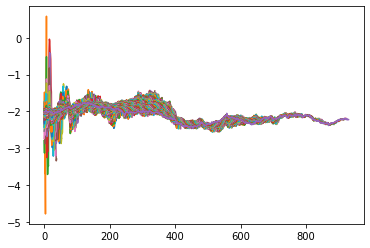

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import gym
import math



#hyper parameters
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 2200000
GAMMA = 0.96
LR = 0.0005
MEMORY_CAPACITY = 40000
Q_NETWORK_ITERATION = 80000
BATCH_SIZE = 64

EPISODES = 12500
NUM_STATES = 24
NUM_ACTIONS = 4

NONE_TENSOR = torch.tensor([np.nan for i in range(NUM_STATES)])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 11, 2)
        self.batch1 = torch.nn.BatchNorm2d(16)
        self.maxpool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 7, 2)
        self.batch2 = torch.nn.BatchNorm2d(32)
        self.maxpool2 = torch.nn.MaxPool2d(2, 2) 
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 2)
        self.batch3 = torch.nn.BatchNorm2d(64)
        #self.maxpool3 = torch.nn.MaxPool2d(2, 2) 
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(9792, 8192)
        self.linear2 = torch.nn.Linear(8192, 4096)
        self.linear3 = torch.nn.Linear(4096, 4096)
        self.linear4 = torch.nn.Linear(4096, 4)

    def forward(self, x):
        #for e in x:
        if x.shape[0] == 1:
            x = torch.reshape(x, (1, 3, 337, 600))
        else:
            x = torch.reshape(x, (32, 3, 337, 600))
        x = F.relu(self.batch1(self.conv1(x)))
        #print(x.shape)
        x = self.maxpool1(x)
        #print(x.shape)
        x = F.relu(self.batch2(self.conv2(x)))
        #print(x.shape)
        x = self.maxpool2(x)
        #print(x.shape)
        x = F.relu(self.batch3(self.conv3(x)))
        #x = self.maxpool3(x)
        x = self.linear1(self.flatten(x))
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

class Dqn():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES *2 +2))
        # state, action ,reward and next state
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()

        self.fig, self.ax = plt.subplots()

    def store_trans(self, state, action, reward, next_state):
        if self.memory_counter % 500 ==0:
            print("The experience pool collects {} time experience".format(self.memory_counter))
        index = self.memory_counter % MEMORY_CAPACITY
        #print(state)
        #print(action)
        #print(reward)
        #print(next_state)
        trans = np.hstack((state, [action], [reward], next_state))
        #print(trans)
        self.memory[index,] = trans
        self.memory_counter += 1

    def choose_action(self, state):
        # notation that the function return the action's index nor the real action
        # EPSILON
        state = torch.unsqueeze(torch.FloatTensor(state) ,0)
        #print(state)
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.learn_counter / EPS_DECAY)
        if np.random.randn() > eps_threshold:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy() # get action whose q is max
            action = action[0] #get the action index
        else:
            action = np.random.randint(0,NUM_ACTIONS)
        #print(f"Chosen action: {action}")
        return action

    def plot(self, ax, x):
        ax.cla()
        ax.set_xlabel("episode")
        ax.set_ylabel("total reward")
        ax.plot(x, 'b-')
        plt.pause(0.000000000000001)

    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION ==0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

        if self.learn_counter % 10000 == 0:
            torch.save(self.target_net, f"./modeldist{self.learn_counter/10000}")
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])
        non_final_mask = torch.tensor(tuple(map(lambda s: not torch.all(s.isnan()), batch_next_state)))
        non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch_next_state if not torch.all(s.isnan())])
        #print(non_final_next_states)
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        #q_next = self.target_net(batch_next_state).detach()
        #print(next_state_values)
        q_target = batch_reward + GAMMA*next_state_values.view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



def main():
    initialState = [[0.0, 0.0, 0.0, 0.0, 0.02564103,  0.0,  0.0, 0.0],
 [0.0,  0.0, 0.0, 0.0,  0.0, 0.0, 0.0,  0.0],
 [0.0,  0.0, 0.0, 0.0,  0.0, 0.0, 0.0,  0.0]]
    net = Dqn()
    print("The DQN is collecting experience...")
    step_counter_list = []
    mean_rewards = []
    for episode in range(EPISODES):
        game = Game()
        state, _, _ = game.on_update(0)
        step_counter = 0
        rewards = []
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = game.on_update(action)
            next_state = torch.flatten(torch.tensor(next_state).float())
            if done:
              next_state = NONE_TENSOR
            #reward = reward * 100 if reward >0 else reward * 5
            net.store_trans(state, action, reward, next_state)
            rewards.append(reward)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
                if done:
                    print("episode {}, the reward is {}".format(episode, round(reward, 3)))
            if done:
                step_counter_list.append(step_counter)
                net.plot(net.ax, step_counter_list)
                break

            state = next_state
        mean_rewards.append(sum(rewards)/len(rewards))
        if episode % 10 == 0:
            running_avg = np.convolve(mean_rewards, np.ones(math.ceil(len(mean_rewards)/4))/math.ceil(len(mean_rewards)/4), mode='valid')
            #plt.plot(mean_rewards)
            np.savetxt("mean_rewards.csv", running_avg, delimiter=",")
            plt.plot(running_avg)
if __name__ == '__main__':
    main()

In [ ]:
!rm fishygame.zip
!zip -r /content/fishygame.zip . -i /fishygame/*
